#  High Dynamic Range

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io, transform, color, filters
import random

In [45]:
# 1. write software to automatically combine multiple exposures into a single high dynamic range radiance map
# 2. convert this radiance map to an image suitable for display through tone mapping

##  Load images

In [46]:
#load in the images
PATH = 'source_images/'
memorial_txt =  np.genfromtxt(PATH+'memorial.hdr_image_list.txt', skip_header=3, dtype = str)

In [52]:
grey_images = []
color_images = []
exposure_length = []
for file in memorial_txt:
    image_path = PATH +  file[0][:-4] + ".png"
    grey_im = cv2.imread(image_path,0)
    color_im = io.imread(image_path)
    grey_images.append(grey_im)
    color_images.append(color_im)
    exposure_length.append(file[1])
grey_images = np.asarray(grey_images)
color_images = np.asarray(color_images)
exposure_length = np.asarray(exposure_length, dtype = np.float64)
exposure_length = 1 / exposure_length
log_ex = np.log(exposure_length)

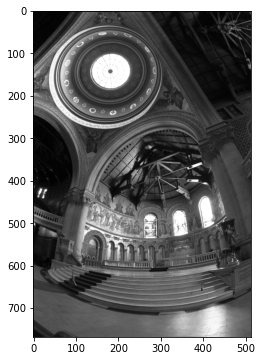

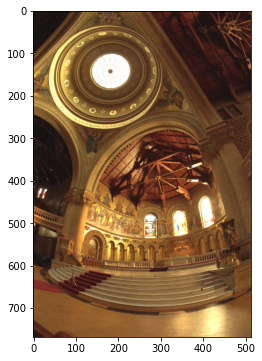

4.0


In [57]:
index = 3
plt.rcParams['figure.figsize'] = [6, 6]
plt.imshow(grey_images[index],cmap = "gray")
plt.show()
plt.imshow(color_images[index])
plt.show()
print(exposure_length[index])

In [ ]:
#input into algorithm is a number (16) of digitized  photogrpaghs with  different  exposures (exposure_length)

In [59]:
# ? - glenn
np.random.uniform()
test.shape

AttributeError: 'float' object has no attribute 'shape'

## Film Response Recovery (2.1 from Debevec and Makil 1997)

In [72]:
def sample_images(Z):
    
    #define middle im to locate intensities
    mid_index = Z.shape[0] // 2
    indexs = []
    
    
    #loop through each intensity and find a pixel that matches
    for i in range(256):
        r, c = np.asarray(Z[mid_index] == i).nonzero()
        if len(r) != 0:
            randint = np.random.randint(0, len(r), 1)
            indexs.append([int(r[randint]), int(c[randint])])
    
    im_values = np.zeros((Z.shape[0], 255))
    for i in range(Z.shape[0]):
        for j in range(len(indexs)):
            index = indexs[j]
            im_values[i][j] = Z[i][index[0], index[1]]
    
    return im_values
    #return 50 samples

In [73]:
sample_im = sample_images(grey_images)

In [110]:
# eqn (4) in paper
def weight_func(intensity):
    if intensity <= (255 / 2):
        return intensity
    return 255 - intensity

In [76]:
#create response curve (FROM CODE IN APPENDIX OF PAPER)

# Z: sample intensities
# B: log of exposure
# l: smoothness constant
# w: weight function

def compute_g(Z, B, l, w):
    
    n = 256
    A = np.zeros((Z.shape[0] * Z.shape[1] + n + 1, n + Z.shape[0]))
    b = np.zeros((A.shape[0], 1))

    #Include the data−fitting equations
    k = 0
    
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
             
            #calculate weight
            wij = w(Z[i, j] + 1)
            
            #calculate A and B
           # print(A.shape)
           # print(k, Z[i,j]+1)
            A[k, int(Z[i, j] + 1)] = wij 
            A[k,n + i] = - wij
            #print(i)
            b[k] = wij * B[i]
            k = k + 1
            
            

    #Fix the curve by setting its middle value to 0

    A[k, 129] = 1
    k = k + 1
    
    # Include the smoothness equations
    for i in range(0, n - 2):
        A[k, i] = l * w(i + 1)
        A[k, i + 1] = -2 * l * w(i + 1)
        A[k, i + 2] = l * w(i + 1)
        k = k + 1;

    #Solve the system using SVD 
    inv_A = np.linalg.pinv(A)
    x = np.dot(inv_A, b)
    g = x[0:n]
    lE = x[n+1:x.shape[0]]
    
    #g: log expsoure corresponding pixel value
    #lE: log film irradiance at pixel location i
    return g, lE

In [77]:
log_ex = np.log(exposure_length)

In [78]:
g,le = compute_g(sample_im, log_ex, 100, weight_func)
g, le

NameError: name 'weight_func' is not defined

## Constructing the High Dynamic Range Radiance Map (2.2 from paper)

In [79]:
def construct_map(Z, w, g, B):
    P = Z.shape[0]
    lnE = np.zeros((Z.shape[1], Z.shape[2]))
    print(lnE.shape)
    
    #for pixel
    for r in range(Z.shape[1]):
        for c in range(Z.shape[2]):
        
            num = 0
            denom = 0

            #sum over all images
            for i in range(Z.shape[0]):

                wij = w(Z[i, r, c])
                gij = g[int(Z[i, r, c])]
                b = B[i]

                num += (wij * gij) - b

                denom += wij

        lnE[r,c] = num / denom 
    return lnE

In [80]:
r_map = construct_map(images, weight_func, g, log_ex)

NameError: name 'images' is not defined

In [81]:
r_map.shape

NameError: name 'r_map' is not defined

## Tone Mapping

In [82]:
# Your input is linear RGB values of radiance.

# Compute the intensity (I) by averaging the color channels.
# Compute the chrominance channels: (R/I, G/I, B/I)
# Compute the log intensity: L = log2(I)
# Filter that with a bilateral filter: B = bf(L)
# Compute the detail layer: D = L - B
# Apply an offset and a scale to the base: B' = (B - o) * s
# The offset is such that the maximum intensity of the base is 1. Since the values are in the log domain, o = max(B).
# The scale is set so that the output base has dR stops of dynamic range, i.e., s = dR / (max(B) - min(B)). Try values between 2 and 8 for dR, that should cover an interesting range. Values around 4 or 5 should look fine.
# Reconstruct the log intensity: O = 2^(B' + D)
# Put back the colors: R',G',B' = O * (R/I, G/I, B/I)
# Apply gamma compression. Without gamma compression the result will look too dark. Values around 0.5 should look fine (e.g. result.^0.5). You can also apply the simple global intensity scaling to your final output.

In [83]:
def avg_channels(im):
    im = color_images[0]
    avg_im = np.zeros(im.shape[:2])
    for x in range(im.shape[0]):
        for y in range(im.shape[1]):
            avg_im[x, y] = np.average(im[x, y, :])
    return avg_im

In [ ]:
#TODO
def tone_mapping(image):
    
        image  = images[i]
        
        # Compute the intensity (I) by averaging the color channels.
        avg_im = avg_channels(image)
        
        # Compute the chrominance channels: (R/I, G/I, B/I)
        chrominance_channels = np.array([image[:,:,i] / avg_im for i in range(3)])
        
        # Compute the log intensity: L = log2(I)
        L = np.log2(avg_im)
        
        # Filter that with a bilateral filter: B = bf(L)
        B = cv2.bilateralFilter(L)
        
        # Compute the detail layer: D = L - B
        D = L - B
        
        # The offset is such that the maximum intensity of the base is 1. Since the values are in the log domain, o = max(B).


        
        
        
        
    # Compute the chrominance channels: (R/I, G/I, B/I)
        
        

In [170]:
im = color_images[0]
avg_im = np.zeros(im.shape[:2])
for x in range(im.shape[0]):
    for y in range(im.shape[1]):
        avg_im[x, y] = np.average(im[x, y, :])
        

In [174]:
chrominance_channels = np.array([im[:,:,i] / avg_im for i in range(3)])

In [176]:
def globalToneMapping(image, gamma):
    image_corrected = cv2.pow(image/255., 1.0/gamma)
    return image_corrected

## Compute HDR

In [230]:
def computeHDR(images, log_ex, smoothing_lamba=100):
    
    hdr_image = np.zeros(images[0].shape)
    
    #run computations on each image channel (r,g,b)
    
    for c in range(images[0].shape[2]):
        print(c)
        channel_images = color_images[:,:,:,c]
        
        #sample intensities
        sample_im = sample_images(channel_images)
        
        #compute g
        g,le = compute_g(sample_im, log_ex, smoothing_lamba, weight_func)
        
        #compute radiance map
        r_map = construct_map(channel_images, weight_func, g, log_ex)
        
        #add channelto hdr image (normalize)
        hdr_image[:,:,c] = r_map
    
    print(hdr_image)
    #tone map
    # TODO do local mapping not gloab
    tone_image = globalToneMapping(hdr_image, 0.6)
    
    # Output image
    final_image = tone_image.copy()
    cv2.normalize(tone_image, dst = final_image, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    return final_image

In [231]:
test  = computeHDR(color_images, log_ex, 100)

0
(272, 1)
(768, 512)
1
(272, 1)
(768, 512)
2
(272, 1)
(768, 512)
[[[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [-0.0883335  -0.04217795 -0.05511537]]

 [[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [-0.09560222 -0.0482825  -0.05917733]]

 [[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [-0.09122826 -0.04788702 -0.06080602]]

 ...

 [[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.

NameError: name 'output' is not defined

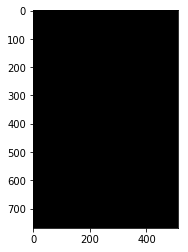

In [211]:
plt.imshow(test)